In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras.applications import VGG16

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'resized_dataset',
    seed = 123,
    shuffle = True,
    image_size=(162,110),
    batch_size=32
)

Found 967 files belonging to 10 classes.


In [3]:
class_names = dataset.class_names

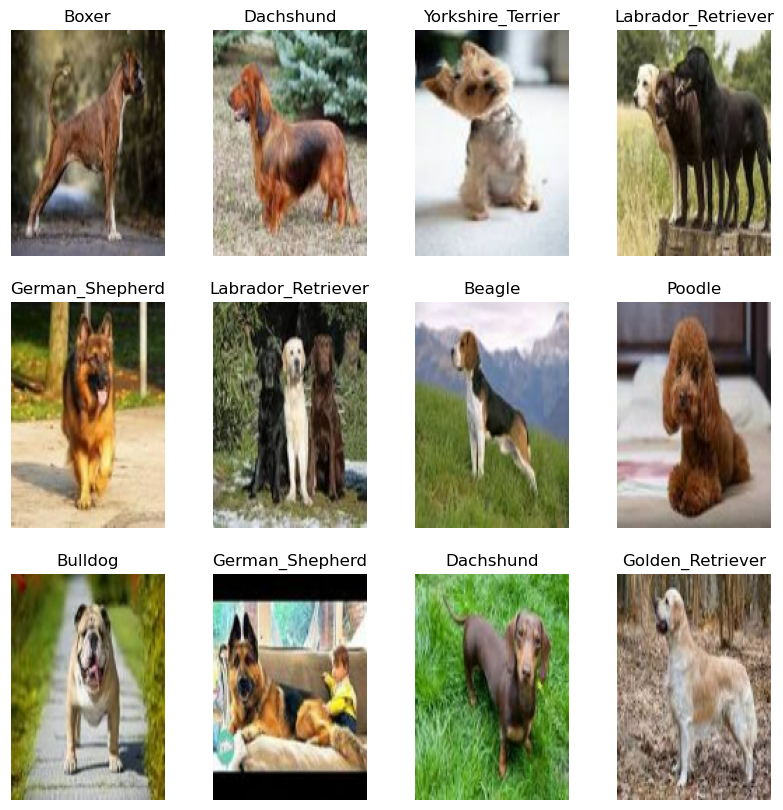

In [4]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        image = image_batch[i].numpy().astype('uint8')
        label = class_names[label_batch[i]]
        plt.imshow(image)
        plt.title(label)
        plt.axis(False)

In [5]:
def split_data(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = sum(1 for _ in dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - (train_size + val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds



In [6]:
train_ds,val_ds,test_ds = split_data(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub

# # Define the feature extractor model URL
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# # Initialize the KerasLayer for the feature extractor
# pretrained_model_without_top_layer = hub.KerasLayer(
#     feature_extractor_model, input_shape=(162, 110, 3), trainable=False)

# # Define the number of output classes
# num_of_breeds = 10

# # Create the input layer
# inputs = tf.keras.Input(shape=(162, 110, 3))

# # Pass the inputs through the pre-trained model
# x = pretrained_model_without_top_layer(inputs)

# # Add a Dense layer for classification
# outputs = tf.keras.layers.Dense(num_of_breeds)(x)

# # Create the model
# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# # Print the model summary
# model.summary()

In [28]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),  # Resize to 224x224
    tf.keras.layers.Rescaling(1./255)    # Rescale pixel values to [0, 1]
])

# Step 2: Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [29]:
input_tensor = tf.keras.Input(shape=(162,110,3))
x = resize_and_rescale(input_tensor)
x = data_augmentation(x)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)


In [30]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

In [31]:
from tensorflow.keras.models import Model

model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [34]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 162, 110, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,416,074 (154.18 MB)

 Trainable params: 25,701,386 (98.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.0886 - loss: 11.5740 - val_accuracy: 0.3958 - val_loss: 1.9105
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2528 - loss: 2.2268 - val_accuracy: 0.4792 - val_loss: 1.7238
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3160 - loss: 1.9240 - val_accuracy: 0.5729 - val_loss: 1.5056
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3877 - loss: 1.7253 - val_accuracy: 0.6354 - val_loss: 1.3577
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4054 - loss: 1.6440 - val_accuracy: 0.6354 - val_loss: 1.2459


In [36]:
acc = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

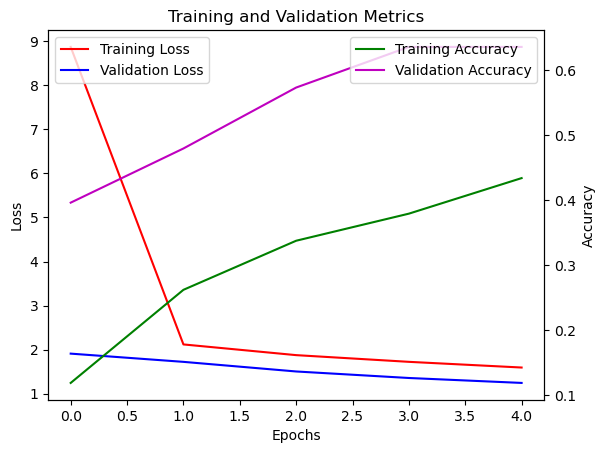

In [37]:
fig, ax1 = plt.subplots()

# Plotting loss vs epochs
ax1.plot(history.history['loss'], label='Training Loss', color='r')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Creating a twin axes sharing the x-axis
ax2 = ax1.twinx()
# Plotting accuracy vs epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='g')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Training and Validation Metrics')
plt.show()

# Transfer Learning is good for larger datasets